In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import mlflow
import os

from sklearn.metrics import r2_score, mean_squared_error
from src.utils import get_metrics

from presentation.pipelines.steps.model_design import load_pt_model
from presentation.pipelines.steps.load_data import build_loader 


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-03-21 13:51:13.735789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pretraining

In [22]:
root = './presentation/results/minmax/2024-03-20_21-42-21/'

astromer, config = load_pt_model(os.path.join(root, 'pretraining'))

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only


In [23]:
pd.DataFrame(config, index=[0])[['arch', 'mask_format', 'm_alpha', 'probed', 'rs', 'scheduler', 'use_leak', 'lr', 'num_heads']]

,arch,mask_format,m_alpha,probed,rs,scheduler,use_leak,lr,num_heads
0,base,Q,0.0,0.5,0.2,True,True,0.00001,4


In [24]:
data_path = './data/records/macho/'
loaders = build_loader(data_path, 
                       config, 
                       batch_size=32,
                       clf_mode=False,
                       sampling=False,
                       normalize='minmax')

[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking
[INFO] Probed: 0.50 Random: 0.20 Same: 0.20
[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


In [25]:
output = astromer.predict(loaders['test'].take(4))

[INFO] Masking Query tokens only
[INFO] Masking Query tokens only
4/4 [==============================] - 1s 121ms/step


In [26]:
y = tf.ragged.boolean_mask(output['magnitudes'], output['probed_mask'])
y_hat = tf.ragged.boolean_mask(output['reconstruction'], output['probed_mask'])

r2_values = []
mse_values = []
for i in range(output['magnitudes'].shape[0]):
    y = tf.boolean_mask(output['magnitudes'][i], output['probed_mask'][i])
    y_hat = tf.boolean_mask(output['reconstruction'][i], output['probed_mask'][i])
    r2_values.append(r2_score(y, y_hat))
    mse_values.append(mean_squared_error(y, y_hat, squared=False))
    
test_r2   = np.mean(r2_values) 
test_mse = np.mean(mse_values)

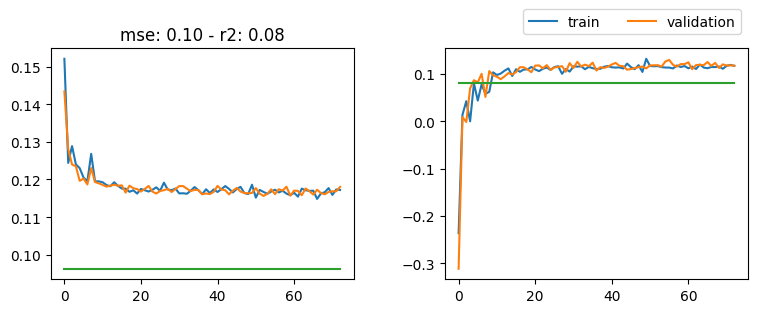

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'wspace':0.3})

for i, metric_name in enumerate(['epoch_loss', 'epoch_r_square']):
    train_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'train'), 
                                metric_name=metric_name)
    valid_metrics = get_metrics(os.path.join(root, 'pretraining', 'tensorboard', 'validation'), 
                                metric_name=metric_name)
    axes[i].plot(train_metrics['step'], train_metrics['value'], label='train')
    axes[i].plot(valid_metrics['step'], valid_metrics['value'], label='validation')
    
    if metric_name == 'epoch_r_square':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_r2, test_r2])
        continue
        
    if metric_name == 'epoch_loss':
        axes[i].plot([0, valid_metrics['step'].iloc[-1]], [test_mse, test_mse])
        continue
        
    axes[i].set_ylabel(metric_name)
    axes[i].set_xlabel('Epoch')
    
axes[0].set_title('mse: {:.2f} - r2: {:.2f}'.format(test_mse, test_r2))
axes[-1].legend(bbox_to_anchor=(1., 1.2), ncols=2)
plt.show()

Text(0.5, 1.0, 'True vs Predicted')

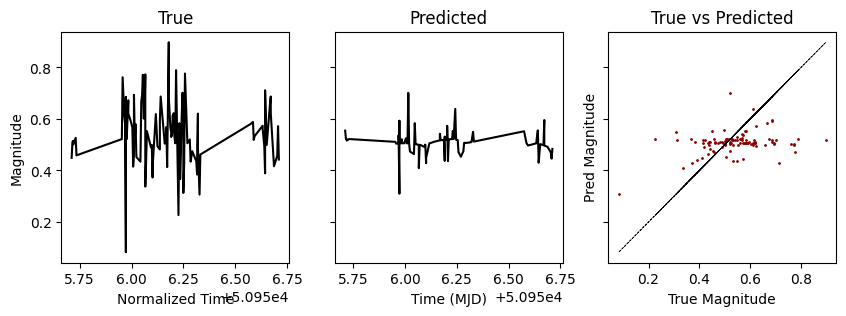

In [28]:
N = 2

x_true = tf.boolean_mask(output['magnitudes'][N], output['probed_mask'][N])
x_pred = tf.boolean_mask(output['reconstruction'][N], output['probed_mask'][N])
times = tf.boolean_mask(output['times'][N], output['probed_mask'][N])

fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.2}, sharey=True)
axes[0].plot(times, x_true, color='k', label='True')
axes[0].set_title('True')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlabel('Normalized Time')
axes[1].plot(times, x_pred, color='k', label='Prediction')
axes[1].set_title('Predicted')
axes[1].set_xlabel('Time (MJD)')
axes[2].scatter(x_true, x_pred, s=1, color='darkred')
axes[2].plot(x_true, x_true, linewidth=0.5, color='k', linestyle='--')

axes[2].set_xlabel('True Magnitude')
axes[2].set_ylabel('Pred Magnitude')
axes[2].set_title('True vs Predicted')

## Finetunem (MLFlow)

In [207]:
runs_df = mlflow.search_runs(experiment_ids=['128374866685660472'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']
runs_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.rmse', 'metrics.validation_rmse',
       'metrics.val_rmse', 'metrics.validation_loss', 'metrics.loss',
       'metrics.val_r_square', 'metrics.r_square', 'metrics.val_loss',
       'metrics.validation_r_square', 'metrics.test_loss', 'metrics.test_r2',
       'metrics.test_rmse', 'params.optimizer_epsilon',
       'params.optimizer_name', 'params.optimizer_is_legacy_optimizer',
       'params.optimizer_weight_decay', 'params.optimizer_clipnorm',
       'params.optimizer_global_clipnorm', 'params.optimizer_amsgrad',
       'params.optimizer_beta_2', 'params.optimizer_ema_overwrite_frequency',
       'params.optimizer_ema_momentum', 'params.optimizer_jit_compile',
       'params.optimizer_beta_1', 'params.optimizer_use_ema',
       'params.optimizer_learning_rate', 'params.optimizer_clipvalue',
       'tags.pe_base', 'tags.fold', 'tags.mixer', 'tags.patience',
       'tags.mlflow.parentR

In [208]:
id_cols = ['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']
    
selected = runs_df[id_cols+['tags.fold', 'metrics.val_rmse', 'metrics.test_r2']]

selected.groupby(id_cols).agg({'metrics.val_rmse': ['mean', 'std'],
                                                                          'metrics.test_r2': ['mean', 'std']})

metrics.val_rmse  \
                                                                                                mean   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc                    
atlas                base      -1000000000.0 0.4         0.0     0.0       100              0.125074   
                                                                           20               0.193511   
                                                                           500              0.105079   
                                             0.5         0.0     0.4       100              0.124856   
                                                                           20               0.137506   
                                                                           500              0.102649   
                               1.0           0.5         0.2     0.2       100              0.223426   
                                                                           20               0.271658   
                                                                           500              0.114172   
macho                base      -1000000000.0 0.4         0.0     0.0       100              0.086588   
                                                                           20               0.027126   
                                                                           500              0.137443   
                                             0.5         0.0     0.4       100              0.079102   
                                                                           20               0.053448   
                                                                           500              0.087468   
                               1.0           0.5         0.2     0.2       100              0.132956   
                                                                           20               0.093864   
                                                                           500              0.133236   

                                                                                               \
                                                                                          std   
tags.downstream_data tags.arch tags.m_alpha  tags.probed tags.rs tags.same tags.spc             
atlas                base      -1000000000.0 0.4         0.0     0.0       100       0.021118   
                                                                           20        0.120352   
                                                                           500       0.071257   
                                             0.5         0.0     0.4       100       0.011952   
                                                                           20        0.011734   
                                                                           500       0.027516   
                               1.0           0.5         0.2     0.2       100       0.019081   
                                                                           20        0.070992   
                                                                           500       0.038058   
macho                base      -1000000000.0 0.4         0.0     0.0       100       0.029615   
                                                                           20        0.000107   
                                                                           500       0.037235   
                                             0.5         0.0     0.4       100       0.014848   
                                                                           20        0.004282   
                                                                           500       0.010329   
                               1.0           0.5         0.2     0.2       100       0.021965   
                                                        

## Classification (MLFlow)

In [139]:
runs_df = mlflow.search_runs(experiment_ids=['852161655664768094'], 
                              search_all_experiments=True)
runs_df = runs_df[runs_df.status == 'FINISHED']

runs_df = runs_df[['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                   'tags.probed', 'tags.rs', 'tags.same', 'tags.spc', 
                   'tags.fold', 'metrics.test_f1']]
runs_df['tags.fold'] = runs_df['tags.fold'].astype(float)
runs_df['metrics.test_f1'] = runs_df['metrics.test_f1'].astype(float)

In [140]:
runs_df.groupby(['tags.downstream_data', 'tags.arch', 'tags.m_alpha', 
                 'tags.probed', 'tags.rs', 'tags.same', 'tags.spc']).agg({'metrics.test_f1': ['mean', 'std']})

metrics.test_f1  \
                                                                                              mean   
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc                   
atlas                base      1.0          0.5         0.2     0.8       100             0.565016   
                                                                          20              0.585054   
                                                                          500             0.651385   
macho                base      1.0          0.5         0.2     0.8       100             0.575650   
                                                                          20              0.233617   
                                                                          500             0.618645   

                                                                                              
                                                                                         std  
tags.downstream_data tags.arch tags.m_alpha tags.probed tags.rs tags.same tags.spc            
atlas                base      1.0          0.5         0.2     0.8       100       0.165939  
                                                                          20        0.076211  
                                                                          500       0.052051  
macho                base      1.0          0.5         0.2     0.8       100       0.039289  
                                                                          20        0.274173  
                                                                          500       0.003478